# Digital Musicology (DH-401)
## Assignment 3: Similarity
Group 6
- Mickaël Achkar
- Yichen Wang
- Yinghui Jiang

In [1]:
import ms3
import pandas as pd
import numpy as np
import math
import fractions
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct, fft
from scipy import signal, interpolate
from itertools import combinations
pd.set_option('display.max_rows', 500)

## 0. Dataset preparation

In [2]:
%%time

# Suppress SettingWithCopy warnings
pd.options.mode.chained_assignment = None

# Import CSV
chorales_dataset = pd.read_csv('DM 2022 - Assignment 3 [Dataset].csv', converters = {'mn_onset': fractions.Fraction, 'act_dur': fractions.Fraction, 'duration': fractions.Fraction, 'nominal_duration': fractions.Fraction, 'scalar': fractions.Fraction}, index_col = 0, low_memory = False)

# Remove Chorale043 because it is corrupted (it does not open in MuseScore, it does not include a closing fermata, and it has only 1 staff)
chorales_dataset = chorales_dataset[chorales_dataset['piece'] != 'BachChorales/Chorale043']

# Remove "BachChorales/" from the piece names for better readability
chorales_dataset['piece'] = chorales_dataset['piece'].str.replace('BachChorales/', '')

## Add global onset column for easy time series manipulations (in units of whole notes)
# Sort accordingly
chorales_dataset = chorales_dataset.sort_values(by=['piece', 'staff', 'mn', 'mn_onset'])
# Shift duration column by 1
chorales_dataset['_shift_dur'] = np.roll(chorales_dataset['duration'], 1)
# Get invalid first shifts that will be removed
chorales_dataset['_first_shift'] = chorales_dataset.groupby(['piece','staff'])['_shift_dur'].transform('first')
# Cumulate shifted durations
chorales_dataset['_cum_dur_uncleaned'] = chorales_dataset.groupby(['piece','staff'])['_shift_dur'].transform(pd.Series.cumsum)
# Subtract invalid first shifts
chorales_dataset['global_onset'] = (chorales_dataset['_cum_dur_uncleaned'] - chorales_dataset['_first_shift'])
# Remove temp coliumns
chorales_dataset = chorales_dataset.drop(columns = ['_shift_dur','_first_shift','_cum_dur_uncleaned'])

# Ignore gracenotes (there is only one)
chorales_dataset = chorales_dataset[chorales_dataset['gracenote'].isna()].drop(columns = ['gracenote'])

# Get unique piece/staff pairs
piece_staffs = chorales_dataset.groupby('piece')['staff'].unique().to_dict()

# Consider only until the fermata in or after the 4th bar
fermata_data = []
for piece in piece_staffs.keys():
    for staff in piece_staffs[piece]:
        for idx, row in chorales_dataset[(chorales_dataset['piece'] == piece) & (chorales_dataset['staff'] == staff)].iterrows():
            fermata_data.append(row)
            if row['fermata'] and row['mn'] >= 4:
                break
fermata_df = pd.DataFrame(fermata_data)

# Sort by onset and staff for consistent alignment
fermata_df = fermata_df.sort_values(by=['piece', 'mn', 'mn_onset', 'staff']).reset_index(drop=True)

# Create dictionaries of last onsets, total piece durations, and smallest notes in each piece for future use
last_piece_onsets = fermata_df.groupby('piece')['global_onset'].max().apply(float).to_dict()
total_piece_durations = fermata_df.groupby(['piece','staff'])['duration'].sum().groupby('piece').max().apply(float).to_dict()
minimum_note_durations = fermata_df.groupby('piece')['duration'].min().apply(float).to_dict()

CPU times: user 19.6 s, sys: 614 ms, total: 20.2 s
Wall time: 24 s


In [3]:
# Display dataframe for random piece up to desired fermata
random_piece = fermata_df['piece'].sample(n=1).item()
random_piece = 'Chorale217'
random_piece_df = fermata_df[(fermata_df['piece'] == random_piece)]
random_piece_df

,piece,mn,mn_onset,timesig,act_dur,staff,voice,duration,nominal_duration,scalar,tied,tpc,midi,fermata,global_onset
15474,Chorale217,1,0,3/4,3/4,1,1,1/4,1/4,1,NaN,0,72,False,0
15475,Chorale217,1,0,3/4,3/4,2,1,1/4,1/4,1,NaN,4,64,False,0
15476,Chorale217,1,0,3/4,3/4,3,1,1/4,1/4,1,NaN,1,55,False,0
15477,Chorale217,1,0,3/4,3/4,4,1,1/4,1/4,1,NaN,0,48,False,0
15478,Chorale217,1,1/4,3/4,3/4,1,1,1/4,1/4,1,NaN,0,72,False,1/4
15479,Chorale217,1,1/4,3/4,3/4,2,1,1/4,1/4,1,NaN,1,67,False,1/4
15480,Chorale217,1,1/4,3/4,3/4,3,1,1/4,1/4,1,NaN,0,60,False,1/4
15481,Chorale217,1,1/4,3/4,3/4,4,1,1/4,1/4,1,NaN,4,52,False,1/4
15482,Chorale217,1,1/2,3/4,3/4,1,1,1/4,1/4,1,NaN,0,72,False,1/2
15483,Chorale217,1,1/2,3/4,3/4,2,1,1/4,1/4,1,NaN,1,67,False,1/2


## I. Similarity parameters

In [4]:
# Small tweak to a tool used frequently to make it more intuitive
def create_time_series(start, end, spacing, include_end=True):
    if include_end:
        return np.arange(start, (end+1e-10), spacing)
    else:
        return np.arange(start, end, spacing)

### a. Rhythm

In [5]:
%%time

# Create dictionary of metrical weights for each piece at each onset
summed_durations_dict = {}
summed_durations_resampled_dict = {}
# Loop
for piece in piece_staffs.keys():
    piece_df = fermata_df[fermata_df['piece'] == piece]
    
    last_onset = last_piece_onsets[piece]
    sampling_period = minimum_note_durations[piece]
    
    # Create equally spaced bins sampled by minimum note resolution
    bins = create_time_series(start=0, end=(last_onset+sampling_period), spacing=sampling_period)
    binned_onsets = pd.cut(piece_df['global_onset'], bins, right = False)
    
    # Create equally spaced bins sampled by minimum note resolution
    bins = create_time_series(start=0, end=101, spacing=1)
    binned_onsets = pd.cut(piece_df['global_onset']/last_onset, bins, right = False)
    
    # Sum durations of notes at each onset to get metrical weights
    summed_durations_dict[piece] = piece_df.groupby(binned_onsets)['duration'].sum().apply(float)    
    
    # Sample 100 equally spaced weights from the original signal (set negative samples to 0)
    N = 100
    summed_durations = summed_durations_dict[piece].values
    summed_durations_resampled_dict[piece] = [max(res, 0) for res in signal.resample(summed_durations, num=N)]  

print(bins)

CPU times: user 6.54 s, sys: 167 ms, total: 6.7 s
Wall time: 8.68 s


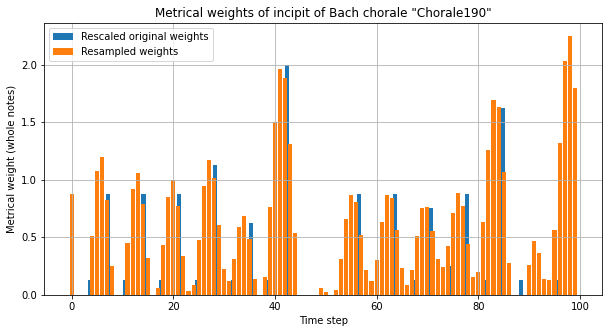

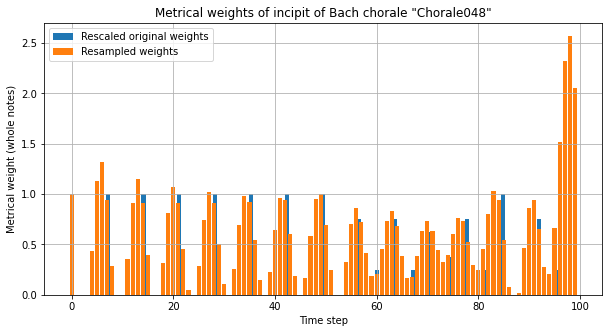

In [6]:
def plot_metrical_weights(piece):
    # Retrieve resampled signal
    time_steps_resampled = np.arange(0, N, 1)
    summed_durations_resampled = summed_durations_resampled_dict[piece]

    # Retrieve original signal
    last_onset = last_piece_onsets[piece]
    sampling_period = minimum_note_durations[piece]
    time_steps = create_time_series(start=0, end=last_onset, spacing=sampling_period)
    # Rescale original signal as the resampled signal for plotting
    time_steps_rescaled = time_steps*(N-1)/last_onset
    summed_durations = summed_durations_dict[piece].values
    
    plt.figure(figsize=(10, 5))
    plt.bar(time_steps_rescaled, summed_durations)
    plt.bar(time_steps_resampled, summed_durations_resampled)
    plt.xlabel('Time step')
    plt.ylabel('Metrical weight (whole notes)')
    plt.title(f'Metrical weights of incipit of Bach chorale "{piece}"')
    plt.legend(['Rescaled original weights', 'Resampled weights'])
    plt.grid()
    plt.show()
    
# Plot metrical weights for 2 random pieces
random_piece_a = fermata_df['piece'].sample(n=1).item()
random_piece_b = fermata_df['piece'].sample(n=1).item()

plot_metrical_weights(random_piece_a)
plot_metrical_weights(random_piece_b)

In [20]:
random_piece_a = fermata_df['piece'].sample(n=1).item()

# Retrieve original signal
last_onset = last_piece_onsets[piece]
sampling_period = minimum_note_durations[piece]
time_steps = create_time_series(start=0, end=last_onset, spacing=sampling_period)
# Rescale original signal as the resampled signal for plotting
time_steps_rescaled = time_steps*(N-1)/last_onset
summed_durations = summed_durations_dict[piece].values

print(time_steps_rescaled)

[ 0.    1.65  3.3   4.95  6.6   8.25  9.9  11.55 13.2  14.85 16.5  18.15
 19.8  21.45 23.1  24.75 26.4  28.05 29.7  31.35 33.   34.65 36.3  37.95
 39.6  41.25 42.9  44.55 46.2  47.85 49.5  51.15 52.8  54.45 56.1  57.75
 59.4  61.05 62.7  64.35 66.   67.65 69.3  70.95 72.6  74.25 75.9  77.55
 79.2  80.85 82.5  84.15 85.8  87.45 89.1  90.75 92.4  94.05 95.7  97.35
 99.  ]


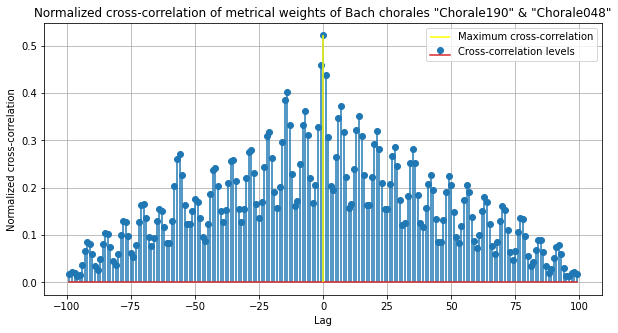

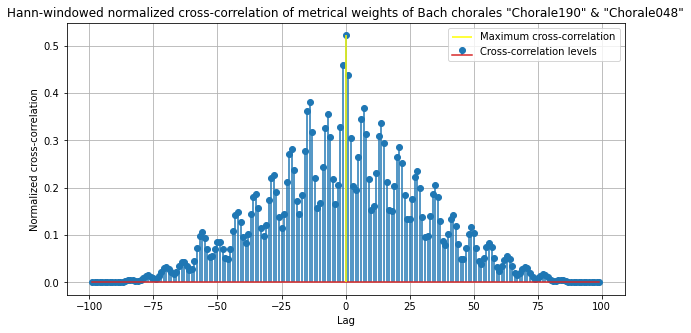

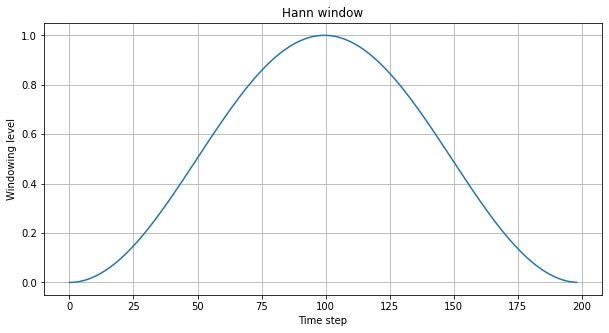

In [7]:
# Cross-corelate the signal pairs of resampled summed durations and normalize them
summed_dur_resampled_a = summed_durations_resampled_dict[random_piece_a]
summed_dur_resampled_b = summed_durations_resampled_dict[random_piece_b]

lags = signal.correlation_lags(N, N)
cross_corr = signal.correlate(summed_dur_resampled_a, summed_dur_resampled_b, 'full')
cross_corr /= N

# Plot the cross-correlation results
plt.figure(figsize=(10, 5))
plt.stem(lags, cross_corr)
plt.vlines(x=np.argmax(cross_corr)-(N-1), ymin=0, ymax=max(cross_corr), color='yellow')
plt.xlabel('Lag')
plt.ylabel('Normalized cross-correlation')
plt.title(f'Normalized cross-correlation of metrical weights of Bach chorales "{random_piece_a}" & "{random_piece_b}"')
plt.legend(['Maximum cross-correlation', 'Cross-correlation levels'])
plt.grid()
plt.show()

# Plot a windowed cross-correlation which gives more importance to scores associated with smaller phase shifts (ie. larger signal overlaps)
window = signal.get_window('hann', N*2-1)

plt.figure(figsize=(10, 5))
plt.stem(lags, cross_corr*window)
plt.vlines(x=np.argmax(cross_corr*window)-(N-1), ymin=0, ymax=max(cross_corr*window), color='yellow')
plt.xlabel('Lag')
plt.ylabel('Normalized cross-correlation')
plt.title(f'Hann-windowed normalized cross-correlation of metrical weights of Bach chorales "{random_piece_a}" & "{random_piece_b}"')
plt.legend(['Maximum cross-correlation', 'Cross-correlation levels'])
plt.grid()
plt.show()

# Plot the chosen window
plt.figure(figsize=(10, 5))
plt.plot(window)
plt.xlabel('Time step')
plt.ylabel('Windowing level')
plt.title(f'Hann window')
plt.grid()
plt.show()

In [8]:
# Get unique combinations of pieces (total of 66430 unique combinations)
piece_pairs = combinations(piece_staffs.keys(), 2)
rhythm_dict = {}
lags = signal.correlation_lags(N, N)
window = signal.get_window('hann', len(lags))

for pair in piece_pairs:
    sig_pair_a = summed_durations_resampled_dict[pair[0]]
    sig_pair_b = summed_durations_resampled_dict[pair[1]]
    
    # Cross-corelate the signal pairs and normalize them
    cross_corr = signal.correlate(sig_pair_a, sig_pair_b, 'full')
    cross_corr /= N
    
    # Window the cross-correlation result and get the norm of the correlation coefficients as a single score
    rhythm_dict[frozenset(pair)] = np.linalg.norm(cross_corr*window, 2)

In [9]:
# Get best and worst rhythm similarities
sorted_rhythm_scores= dict(sorted(rhythm_dict.items(), key=lambda item: item[1], reverse = True)) 

N_tops = 50
print(f'\nTop {N_tops} rhythm similarity scores:')
print('\nBest                                        |   Worst')
print('------------------------------------------------------------------------------------------')
for b,w in zip(range(N_tops), range(-1,-N_tops-1,-1)):
    score_best = list(sorted_rhythm_scores.items())[b]
    score_worst = list(sorted_rhythm_scores.items())[w]
    print(f'{b+1: <2}: {tuple(score_best[0])}: {round(score_best[1], 5): <8}  |   {-w: <2}: {tuple(score_worst[0])}: {round(score_worst[1], 5)} | ')
    print(fermata_df[fermata_df['piece'] == list(score_best[0])[0]]['timesig'].sample(n=1).item())
    print(fermata_df[fermata_df['piece'] == list(score_best[0])[1]]['timesig'].sample(n=1).item())


Top 50 rhythm similarity scores:

Best                                        |   Worst
------------------------------------------------------------------------------------------
1 : ('Chorale320', 'Chorale130'): 9.62591   |   1 : ('Chorale270', 'Chorale247'): 0.22125 | 
4/4
4/4
2 : ('Chorale358', 'Chorale320'): 9.62463   |   2 : ('Chorale195', 'Chorale270'): 0.23093 | 
4/4
4/4
3 : ('Chorale358', 'Chorale130'): 9.6194    |   3 : ('Chorale086', 'Chorale270'): 0.23093 | 
4/4
4/4
4 : ('Chorale217', 'Chorale012'): 9.61342   |   4 : ('Chorale270', 'Chorale305'): 0.23111 | 
3/4
3/4
5 : ('Chorale217', 'Chorale320'): 9.57587   |   5 : ('Chorale195', 'Chorale247'): 0.23512 | 
3/4
4/4
6 : ('Chorale217', 'Chorale130'): 9.55765   |   6 : ('Chorale086', 'Chorale247'): 0.23512 | 
3/4
4/4
7 : ('Chorale358', 'Chorale217'): 9.5496    |   7 : ('Chorale305', 'Chorale247'): 0.2352 | 
4/4
3/4
8 : ('Chorale320', 'Chorale012'): 9.3853    |   8 : ('Chorale195', 'Chorale305'): 0.25392 | 
4/4
3/4
9 : ('Chorale

### b. Melodic contour

In [10]:
%%time

# Create dictionary of pitches for each piece and staff for the duration of each onset
piece_staff_pitches_dict = {}
# Loop
for piece in piece_staffs.keys():
    for staff in piece_staffs[piece]:
        piece_staff_df = fermata_df[(fermata_df['piece'] == piece) & (fermata_df['staff'] == staff)]

        total_duration = total_piece_durations[piece]
        sampling_period = minimum_note_durations[piece]
        
        # Create equally spaced and normalized bins sampled by minimum note resolution
        bins =  create_time_series(start=0, end=1, spacing=sampling_period/total_duration)
        binned_onsets = pd.cut(piece_staff_df['global_onset'], bins, right = False)
        # Front-fill midi values for as long as the onset lasts  
        piece_staff_pitches_dict[(piece,staff)] = piece_staff_df.groupby(binned_onsets)['midi'].first().ffill()

# Get mean pitches for each piece
# This is done by calculating the sum of pitches across staves and dividing by the number of staves
mean_pitches_dict = {}
for piece in piece_staffs.keys():
    cumsum = 0
    for staff in piece_staffs[piece]:
        cumsum += piece_staff_pitches_dict[(piece,staff)]
    num_staves = max(piece_staffs[piece])
    mean_pitches_dict[piece] = cumsum / num_staves

# Manipulate data to get time series vs. pitches for each piece
melodic_contours = {}
for piece in piece_staffs.keys():
    time_steps = create_time_series(start=0, end=1, spacing=minimum_note_durations[piece]/total_piece_durations[piece])
    pitches = mean_pitches_dict[piece].values
    # Front fill up to final normalized duration
    pitches = np.append(pitches, pitches[-1])
    melodic_contours[piece] = (time_steps,pitches)

CPU times: user 16.7 s, sys: 271 ms, total: 17 s
Wall time: 17.7 s


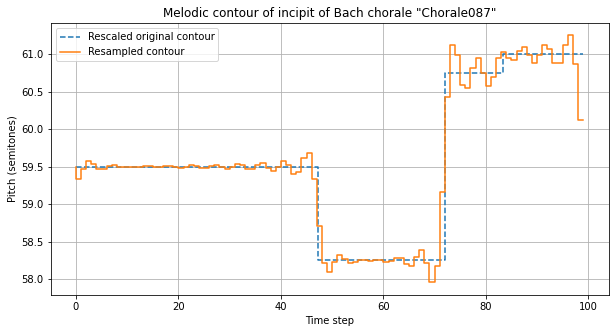

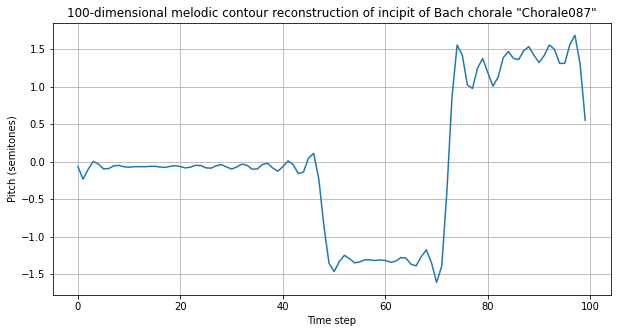

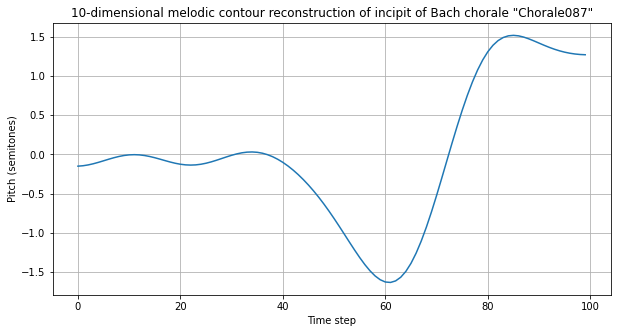

In [11]:
# Plot melodic contour of a random phrase
random_piece = fermata_df['piece'].sample(n=1).item()

time_steps = melodic_contours[random_piece][0]
pitches = melodic_contours[random_piece][1]

# Sample 100 equally spaced pitches
N = 100
time_steps_resampled = np.arange(0, N, 1)
pitches_resampled = signal.resample(pitches, num=N)

# Rescale original signal as the resampled signal for plotting
time_steps_rescaled = time_steps*(N-1)

plt.figure(figsize=(10, 5))
plt.step(time_steps_rescaled, pitches, '--', time_steps_resampled, pitches_resampled, '-')
plt.xlabel('Time step')
plt.ylabel('Pitch (semitones)')
plt.title(f'Melodic contour of incipit of Bach chorale "{random_piece}"')
plt.legend(['Rescaled original contour', 'Resampled contour'])
plt.grid()
plt.show()

# Compute Discrete Cosine transform of signal
phrase_dct = dct(pitches_resampled, norm='ortho', n=N)

# Discard first coefficient c0 to make contour transposition invariant
phrase_dct[0] = 0

# Reconstruct the phrase using all dimensions dimensions
D = 100
reconstructed_phrase = idct(phrase_dct[0:D], norm='ortho', n=N)
plt.figure(figsize=(10, 5))
plt.title(f'{D}-dimensional melodic contour reconstruction of incipit of Bach chorale "{random_piece}"')
plt.xlabel('Time step')
plt.ylabel('Pitch (semitones)')
plt.grid()
plt.plot(reconstructed_phrase)
plt.show()

# Reconstruct the phrase using only D dimensions
D = 10
reconstructed_phrase = idct(phrase_dct[0:D], norm='ortho', n=N)
plt.figure(figsize=(10, 5))
plt.title(f'{D}-dimensional melodic contour reconstruction of incipit of Bach chorale "{random_piece}"')
plt.xlabel('Time step')
plt.ylabel('Pitch (semitones)')
plt.grid()
plt.plot(reconstructed_phrase)
plt.show()

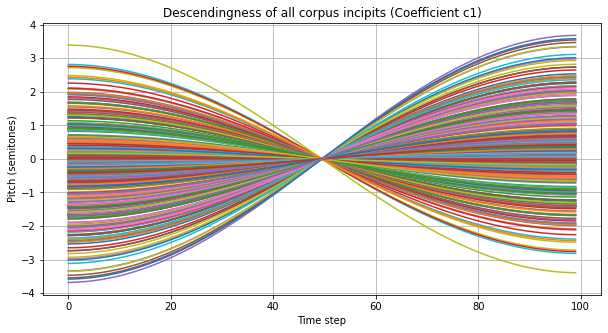

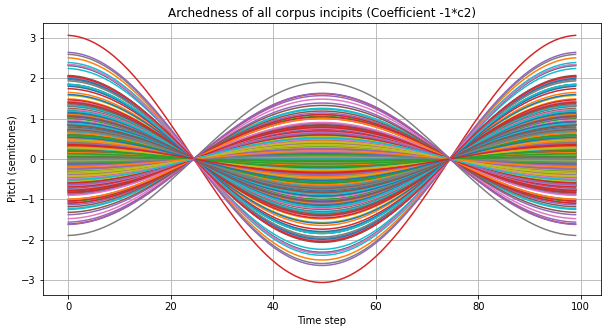

In [12]:
# For visualization, plot the descendingness contours of all phrases
plt.figure(figsize=(10, 5))
plt.title("Descendingness of all corpus incipits (Coefficient c1)")
plt.xlabel('Time step')
plt.ylabel('Pitch (semitones)')
plt.grid()
for piece in piece_staffs.keys():
    time_steps = melodic_contours[piece][0]
    pitches = melodic_contours[piece][1]
    
    # Sample 100 equally spaced pitches
    N = 100
    time_steps_resampled = np.arange(0, N, 1)
    pitches_resampled = signal.resample(pitches, num=N)

    # Compute Discrete Cosine transform of signal
    desc_dct = dct(pitches_resampled, norm='ortho', n=N)

    # Discard first coefficient c0 to make contour transposition invariant
    desc_dct[0] = 0

    # Plot "descendingness" c1 coefficients reconstructions for all phrases
    D = 2
    phrase_descendingness = idct(desc_dct[0:D], norm='ortho', n=N)
    plt.plot(phrase_descendingness)

# For visualization, plot the archedness contours of all phrases
plt.figure(figsize=(10, 5))
plt.title("Archedness of all corpus incipits (Coefficient -1*c2)")
plt.xlabel('Time step')
plt.ylabel('Pitch (semitones)')
plt.grid()
for piece in piece_staffs.keys():
    time_steps = melodic_contours[piece][0]
    pitches = melodic_contours[piece][1]

    # Sample 100 equally spaced pitches
    N = 100
    time_steps_resampled = np.arange(0, N, 1)
    time_steps_resampled = np.arange(0, 100, 1)
    pitches_resampled = signal.resample(pitches, num=100)

    # Compute Discrete Cosine transform of signal
    arch_dct = dct(pitches_resampled, norm='ortho', n=100)

    # Discard first coefficient c0 to make contour transposition invariant
    arch_dct[0] = 0    
    # Discard second coefficient c1 to only represent c2
    arch_dct[1] = 0

    # Plot "archedness" -1*c2 coefficients reconstructions for all phrases
    D = 3
    reconstructed_phrase_archedness = idct(-1*arch_dct[0:D], norm='ortho', n=100)
    plt.plot(reconstructed_phrase_archedness)

In [13]:
# Compute first D cosine transform coefficients for each phrase for a low-dimensional melody represenation

cosine_coeffs = {}
for piece in piece_staffs.keys():
    pitches = melodic_contours[piece][1]

    # Sample 100 equally spaced pitches
    N = 100
    pitches_resampled = signal.resample(pitches, num=N)

    # Compute Discrete Cosine transform of signal
    phrase_dct = dct(pitches_resampled, norm='ortho', n=N)

    # Discard first coefficient c0 to make contour transposition invariant
    phrase_dct[0] = 0

    # Get only D coefficients for a low-dimensional representation
    D = 10
    cosine_coeffs[piece] = phrase_dct[0:D]

# Get unique combinations of pieces (total of 66430 unique combinations)
piece_pairs = combinations(piece_staffs.keys(), 2)
melody_dict = {}

# Get Euclidian distance (L2 norm) between two pairs
for pair in piece_pairs:
    L2_norm = np.linalg.norm(cosine_coeffs[pair[0]] - cosine_coeffs[pair[1]], 2)
    melody_dict[frozenset(pair)] = L2_norm

In [14]:
# Get best and worst melodic contour similarities
sorted_melody_scores= dict(sorted(melody_dict.items(), key=lambda item: item[1])) 

N_tops = 50
print(f'\nTop {N_tops} melodic contour similarity scores:')
print('\nBest                                        |   Worst')
print('------------------------------------------------------------------------------------------')
for b,w in zip(range(N_tops), range(-1,-N_tops-1,-1)):
    score_best = list(sorted_melody_scores.items())[b]
    score_worst = list(sorted_melody_scores.items())[w]
    print(f'{b+1: <2}: {tuple(score_best[0])}: {round(score_best[1], 5): <8}  |   {-w: <2}: {tuple(score_worst[0])}: {round(score_worst[1], 5)}')


Top 50 melodic contour similarity scores:

Best                                        |   Worst
------------------------------------------------------------------------------------------
1 : ('Chorale361', 'Chorale009'): 0.0       |   1 : ('Chorale314', 'Chorale238'): 51.74228
2 : ('Chorale088', 'Chorale023'): 0.0       |   2 : ('Chorale314', 'Chorale179'): 51.26098
3 : ('Chorale036', 'Chorale097'): 0.0       |   3 : ('Chorale314', 'Chorale108'): 51.11201
4 : ('Chorale053', 'Chorale178'): 0.0       |   4 : ('Chorale347', 'Chorale314'): 50.98839
5 : ('Chorale062', 'Chorale112'): 0.0       |   5 : ('Chorale314', 'Chorale212'): 50.80986
6 : ('Chorale098', 'Chorale080'): 0.0       |   6 : ('Chorale314', 'Chorale243'): 48.65572
7 : ('Chorale086', 'Chorale195'): 0.0       |   7 : ('Chorale314', 'Chorale168'): 48.60572
8 : ('Chorale086', 'Chorale305'): 0.0       |   8 : ('Chorale220', 'Chorale314'): 48.37716
9 : ('Chorale259', 'Chorale091'): 0.0       |   9 : ('Chorale314', 'Chorale234'): 4

## c. Harmony

In [15]:
%%time 

# Group pitches by global_onset for each phrase (preserves unisons)
chords_df = fermata_df.groupby(['piece','global_onset'])['midi'].apply(list).reset_index()

# Get only chords (2 or more pitches at the same onset)
mask = [i for i in range(len(chords_df)) if len(chords_df['midi'][i]) != 1]
# Apply mask to get chords and rename column
chords_df = chords_df.iloc[mask].rename(columns={'midi':'chord'})
chords_df

CPU times: user 508 ms, sys: 12.4 ms, total: 521 ms
Wall time: 571 ms


,piece,global_onset,chord
0,Chorale001,0,"[67, 62, 59, 43]"
1,Chorale001,1/4,"[67, 62, 59, 55]"
2,Chorale001,1/2,"[64, 60, 52]"
4,Chorale001,3/4,"[74, 62, 57, 54]"
5,Chorale001,1,"[71, 62, 55, 55]"
...,...,...,...
9219,Chorale371,3,"[67, 64, 59, 55]"
9221,Chorale371,13/4,"[66, 64, 59, 59]"
9222,Chorale371,27/8,"[64, 63]"
9224,Chorale371,7/2,"[66, 63, 47]"


In [16]:
# Create a map between intervals in semitones and interval qualities, and additional consonance/dissonance classes
interval_labels = ['P1/P8', 'm2/M7', 'M2/m7', 'm3/M6', 'M3/m6', 'P4/P5', '4+/5°', 
                   'Consonances (P1/P8, m3/M6, M3/m6, P4/P5)', 'Dissonances (m2/M7, M2/m7, 4+/5°)']
interval_map = [{0}, {1,11}, {2,10}, {3,9}, {4,8}, {5,7}, {6}, {0,3,9,4,8,5,7}, {1,11,2,10,6}]

# Create interval qualities frequency vectors for each phrase
harmony_vectors = {}
for piece in piece_staffs.keys():
    interval_classes = np.zeros(9)
    for chord in chords_df[(chords_df['piece'] == piece)]['chord']:
        # Get all unique interval combinations in a chord
        for comb in combinations(chord, 2):
            for key,interval in enumerate(interval_map):
                # Convert interval to chromatic pitch-class ordered in semitones
                cpc_comb = (comb[0]-comb[1])%12
                # Map the interval size to its quality
                if cpc_comb in interval:
                    interval_classes[key] += 1
    # Normalize by total interval counts per piece
    harmony_vectors[piece] = interval_classes / sum(interval_classes[7:9])

In [17]:
# Get interval class vector of a random phrase
random_piece = fermata_df['piece'].sample(n=1).item()

print(f'Interval class frequencies of incipit of chorale {random_piece}:\n')
for label, freq in zip(interval_labels[0:7], harmony_vectors[random_piece][0:7]):
    print(f'{label: <41}| {round(freq*100, 2): <6}%')
print('--------------------------------------------------')
for label, freq in zip(interval_labels[7:9], harmony_vectors[random_piece][7:9]):
    print(f'{label: <41}| {round(freq*100, 2): <6}%')

Interval class frequencies of incipit of chorale Chorale250:

P1/P8                                    | 16.51 %
m2/M7                                    | 0.92  %
M2/m7                                    | 4.59  %
m3/M6                                    | 25.69 %
M3/m6                                    | 25.69 %
P4/P5                                    | 24.77 %
4+/5°                                    | 1.83  %
--------------------------------------------------
Consonances (P1/P8, m3/M6, M3/m6, P4/P5) | 92.66 %
Dissonances (m2/M7, M2/m7, 4+/5°)        | 7.34  %


In [18]:
# Get unique combinations of pieces (total of 66430 unique combinations)
piece_pairs = combinations(piece_staffs.keys(), 2)
harmony_dict = {}

# Get Euclidian distance (L2 norm) between two pairs
for pair in piece_pairs:
    L2_norm = np.linalg.norm(harmony_vectors[pair[0]] - harmony_vectors[pair[1]], 2)
    harmony_dict[frozenset(pair)] = L2_norm

In [19]:
# Get best and worst harmonic content similarities
sorted_harmony_scores= dict(sorted(harmony_dict.items(), key=lambda item: item[1])) 

N_tops = 50
print(f'\nTop {N_tops} harmonic content similarity scores:')
print('\nBest                                        |   Worst')
print('-----------------------------------------------------------------------------------------')
for b,w in zip(range(N_tops), range(-1,-N_tops-1,-1)):
    score_best = list(sorted_harmony_scores.items())[b]
    score_worst = list(sorted_harmony_scores.items())[w]
    print(f'{b+1: <2}: {tuple(score_best[0])}: {round(score_best[1], 5): <8}  |   {-w: <2}: {tuple(score_worst[0])}: {round(score_worst[1], 5)}')


Top 50 harmonic content similarity scores:

Best                                        |   Worst
-----------------------------------------------------------------------------------------
1 : ('Chorale005', 'Chorale309'): 0.0       |   1 : ('Chorale217', 'Chorale331'): 0.3807
2 : ('Chorale361', 'Chorale009'): 0.0       |   2 : ('Chorale217', 'Chorale283'): 0.3766
3 : ('Chorale053', 'Chorale178'): 0.0       |   3 : ('Chorale335', 'Chorale283'): 0.37333
4 : ('Chorale256', 'Chorale064'): 0.0       |   4 : ('Chorale298', 'Chorale283'): 0.37244
5 : ('Chorale296', 'Chorale079'): 0.0       |   5 : ('Chorale296', 'Chorale283'): 0.37096
6 : ('Chorale086', 'Chorale195'): 0.0       |   6 : ('Chorale079', 'Chorale283'): 0.37096
7 : ('Chorale086', 'Chorale305'): 0.0       |   7 : ('Chorale283', 'Chorale249'): 0.36933
8 : ('Chorale259', 'Chorale091'): 0.0       |   8 : ('Chorale316', 'Chorale283'): 0.36763
9 : ('Chorale093', 'Chorale257'): 0.0       |   9 : ('Chorale334', 'Chorale283'): 0.36549
10: